In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pickle

from src.tensor import Tensor
from src.activation import ReLU
from src.loss import CrossEntropy
from src.module import Linear, Conv2d, ResidualBlock, Flatten
from src.model import Sequential
from src.optim import SGD
from src.metrics import Accuracy, Precision, Recall

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

X = X.astype(np.float32)[:20000]
y = y.astype(np.int32)[:20000]

X = X/255.0
X = X.reshape(-1, 1, 28, 28)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(y.shape)
print(X.shape)

(20000,)
(20000, 1, 28, 28)


In [ ]:
EPOCHS = 3
LR = 1e-2
BATCH_SIZE = 64

In [ ]:
resnet_model = Sequential(layers=[
                Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
                ReLU(),
                ResidualBlock(4,4),
                Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
                ReLU(),
                ResidualBlock(8,8),
                Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
                ReLU(),
                Flatten(),
                Linear(in_features=16*14*14, out_features=128),
                ReLU(),
                Linear(in_features=128, out_features=10)
        ])

In [ ]:
loss_fn = CrossEntropy()
optimizer = SGD(params=resnet_model.params(), lr=LR)

In [ ]:
num_samples = X.shape[0]

for epoch in range(EPOCHS):
    total_loss = 0
    num_batches = 0
    
    indices = np.random.permutation(num_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    for i in range(0, num_samples, BATCH_SIZE):
        batch_indices = indices[i:i+BATCH_SIZE]
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        X_batch = Tensor(X_batch)
        y_batch = Tensor(y_batch)
        outputs = resnet_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data.item()
        num_batches += 1
        if (i % 200 == 0 and i != 0):
            print(total_loss/i)
    
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")

0.037382044792175294
0.03638659708201885
0.035683496495087945
0.03316223245114088
0.02884095248579979
0.02558138480720421
0.02299213385209441
0.020892300269333645
0.01925242169967128
0.017749765468295663
0.016570966112935407
0.015589218062426274
Epoch 1/3, Average Loss: 0.9673
0.0036734107229858637
0.0038255406497046352
0.003918652065719167
0.004023912278935313
0.00390186161827296
0.003777862909870843
0.00373469492986
0.0037291216864832675
0.0036510969509577587
0.0035656371505465357
0.00346738529603251
0.0034096592012792825
Epoch 2/3, Average Loss: 0.2151
0.002252399795688689
0.0023564676268142647
0.0022640353893317905
0.0023337935139716138
0.0023552300675073637
0.0023901559925676944
0.0023117200369181645
0.002251836383002228
0.002207337004559425
0.0022098733632010406
0.0021792850567726417
0.0021870578224479687
Epoch 3/3, Average Loss: 0.1389


In [ ]:
def show_predictions(model, images, labels, num_images):
    if isinstance(images, Tensor):
        images_np = images.data
    else:
        images_np = images

    if isinstance(labels, Tensor):
        labels_np = labels.data
    else:
        labels_np = labels

    total = images_np.shape[0]
    indices = np.random.choice(total, num_images, replace=False)

    sample_images = images_np[indices]
    sample_labels = labels_np[indices]

    x = Tensor(sample_images, requires_grad=False)

    outputs = model(x)
    preds = np.argmax(outputs.data, axis=1)
    print(preds)

    plt.figure(figsize=(num_images * 1.5, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_images[i][0], cmap='gray')
        plt.title(f"Pred: {preds[i]}\nTrue: {sample_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# with open("model.pkl", "rb") as f:
#     resnet_model = pickle.load(f)

[5 4 2 9 6 9 4 2 6 3]


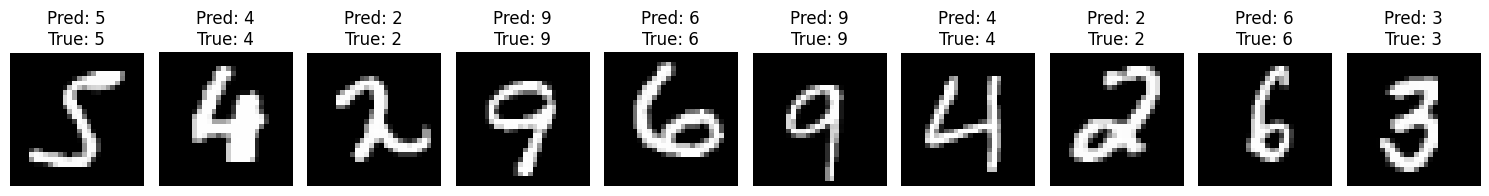

In [ ]:
show_predictions(resnet_model, X_test, y_test, num_images=10)

In [ ]:
def evaluate_model(model, images, labels):
    all_preds = []
    all_labels = []

    for i in range(0, len(images), BATCH_SIZE):
        batch_imgs = images[i:i+BATCH_SIZE]
        batch_labels = labels[i:i+BATCH_SIZE]

        batch_tensor = Tensor(batch_imgs, requires_grad=False)
        outputs = model(batch_tensor)
        preds = np.argmax(outputs.data, axis=1)

        all_preds.append(preds)
        all_labels.append(batch_labels)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = Accuracy(all_preds, all_labels)
    precision = Precision(all_preds, all_labels)
    recall = Recall(all_preds, all_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [ ]:
evaluate_model(resnet_model, X_test, y_test)

Accuracy: 0.9645
Precision: 0.9658
Recall: 0.9630
